# Binary Classification "Hello World"
## Sentiment analysis on Rotten Tomatoes movie reviews

The main (and sole) purpose of this notebook is to play around with data in order to better understand how **Binary Classification** works.

It does not offer a solution to the [Kaggle Sentiment Analisys competition](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews). In fact, the provided dataset has been (drastically) simplified.

Heavily based on this [Classification with scikit learn blog](https://www.datarobot.com/blog/classification-with-scikit-learn/).

## Import & inspect data
Data set taken from [Kaggle: Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data).

Some examples:

  * 4 (positive): "They works spectacularly well... A shiver-inducing, nerve-rattling ride."
  * 3 (somewhat positive): "rooted in a sincere performance by the title character undergoing midlife crisis"
  * 2 (neutral): "Its everything you would expect -- but nothing more."
  * 1 (somewhat negative): "But it does not leave you with much."
  * 0 (negative): "The movies progression into rambling incoherence gives new meaning to the phrase fatal script error."

In [169]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# this allows plots to appear directly in the notebook
%matplotlib inline

# prettify charts
plt.style.use('ggplot')

In [176]:
phrases = pd.read_csv('d:/docs/ml/datas/movies/train.tsv', sep = '\t', index_col = 0)

In [177]:
phrases.head()

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,A series of escapades demonstrating the adage ...,1
2,1,A series of escapades demonstrating the adage ...,2
3,1,A series,2
4,1,A,2
5,1,series,2


In [173]:
phrases.shape

(156060, 3)

### Sheer curiosity: what do some sentences look like?

In [178]:
# print the first sentence
phrases.iloc[0]['Phrase']

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [182]:
# print the third sentence
phrases.loc[lambda row: row.SentenceId == 3].iloc[0]['Phrase']

"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one ."

## Tamper with the given data

Steps to follow:
  * extract short phrases (words?) in two lists: positives (sentiment = 4) and negatives (sentiment = 0)
  * **classify** the whole sentences according to the number of such contained words.

Pretty dumb classification criterion, taking into consideration that the words themselves have been extracted from the sentences, but it should fit our purpose.

### Simplify it

Keep only relevant ("sentimental") phrases, i.e. those with either a strictly positive sentiment label (4) or with a strictly negative one (0).

In [201]:
phrases = phrases[(phrases.Sentiment == 0) | (phrases.Sentiment == 4)]
phrases.shape

(11262, 6)

### Count words

In [202]:
import re
re.findall('\w+', " a,   bee and don't see.")

['a', 'bee', 'and', 'don', 't', 'see']

In [203]:
phrases['WordsCount'] = phrases.apply(lambda row: len(re.findall('\w+', row['Phrase'])), axis = 1)
phrases.head()

,SentenceId,Phrase,Sentiment,WordsCount,PositivesCount,NegativesCount
PhraseId,,,,,,
64,2,"This quiet , introspective and entertaining in...",4,9,2,0
67,2,"quiet , introspective and entertaining indepen...",4,5,1,0
75,2,entertaining,4,1,1,0
78,2,is worth seeking,4,3,1,0
118,4,A positively thrilling combination of ethnogra...,4,23,1,0


### Build collections of positive & negative words, respectively

In [204]:
positives = phrases[(phrases['WordsCount'] <= 3) & (phrases['Sentiment'] == 4)]
# positives.drop_duplicates(subset = 'Phrase')
positives.head()
positives.shape

(1990, 6)

In [205]:
negatives = phrases[(phrases['WordsCount'] <= 3) & (phrases['Sentiment'] == 0)]
# negatives.drop_duplicates(subset = 'Phrase')
# negatives.head()
negatives.shape

(1189, 6)

### Count the positives and the negatives within each phrase...

In [191]:
posphrases = positives['Phrase'].values

In [192]:
negphrases = negatives['Phrase'].values

In [193]:
def count_occurences(phrase, sublist):
    counter = 0
    for sub in sublist:
        counter += phrase.count(sub)
    return counter

In [194]:
# test
count_occurences("thrilling and high hilarity", posphrases)

2

In [195]:
phrases['PositivesCount'] = phrases.apply(
    lambda row: count_occurences(row['Phrase'], posphrases), axis = 1)

phrases['NegativesCount'] = phrases.apply(
    lambda row: count_occurences(row['Phrase'], negphrases), axis = 1)

In [196]:
phrases.head()

,SentenceId,Phrase,Sentiment,WordsCount,PositivesCount,NegativesCount
PhraseId,,,,,,
64,2,"This quiet , introspective and entertaining in...",4,9,2,0
67,2,"quiet , introspective and entertaining indepen...",4,5,1,0
75,2,entertaining,4,1,1,0
78,2,is worth seeking,4,3,1,0
102,3,would have a hard time sitting through this one,0,9,0,0


In [197]:
# remove phrases with 0 negatives and 0 positives
phrases = phrases[phrases.PositivesCount + phrases.NegativesCount > 0]
phrases.shape

(11262, 6)

### Now for the drawing part...

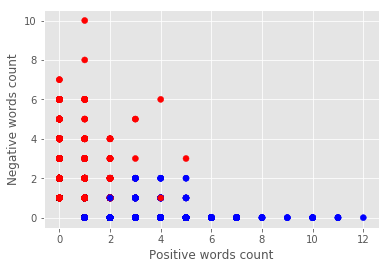

In [198]:
# scatter plot of positive phrases (x) and negative phrases (y)
ax1 = plt.gca()
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax1.scatter(phrases.PositivesCount, 
            phrases.NegativesCount, 
            c = (phrases.Sentiment == 4), 
            cmap = cm_bright)
ax1.set_xlabel('Positive words count')
ax1.set_ylabel('Negative words count')

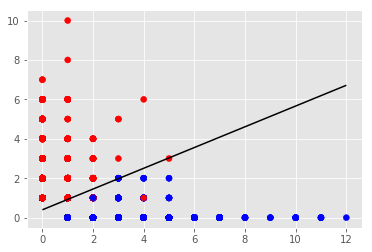

In [199]:
from sklearn.linear_model import LinearRegression

# get feature/predictor matrix as numpy array
X = phrases[['PositivesCount', 'NegativesCount']].values

# encode class labels
classes, y = np.unique(phrases.Sentiment.values, return_inverse = True)

newy = []
for v in y:
    if v == 0:
        newy.append(-1)
    else:
        newy.append(1)
y = newy
# map {0, 4} to {-1, 1}

# fit OLS regression 
est = LinearRegression(fit_intercept=True, normalize=True)
est.fit(X, y)

# plot data and decision surface
ax = plt.gca()
ax.scatter(phrases.PositivesCount, 
           phrases.NegativesCount, 
           c = (phrases.Sentiment == 4), 
           cmap = cm_bright)
plot_surface(est, X[:, 0], X[:, 1], ax=ax)

## Confusion matrix and error rate

In [200]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

# the larger operator will return a boolean array which we will cast as integers for fancy indexing
y_pred = (2 * (est.predict(X) > 0.0)) - 1

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data = cm, columns = [-1, 1], index = [-1, 1])
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm

confusion_matrix(y, y_pred)

error rate: 0.07


Predicted label,-1,1
True label,,
-1,3732,611
1,180,6739


### Appendix
Entirely copy-pasted from the named blog.

In [116]:
# utility function to plot the decision surface
def plot_surface(est, x_1, x_2, ax=None, threshold=0.0, contourf=False):
    """Plots the decision surface of ``est`` on features ``x1`` and ``x2``. """
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))
    # plot the hyperplane by evaluating the parameters on the grid
    X_pred = np.c_[xx1.ravel(), xx2.ravel()]  # convert 2d grid into seq of points
    if hasattr(est, 'predict_proba'):  # check if ``est`` supports probabilities
        # take probability of positive class
        pred = est.predict_proba(X_pred)[:, 1]
    else:
        pred = est.predict(X_pred)
    Z = pred.reshape((100, 100))  # reshape seq to grid
    if ax is None:
        ax = plt.gca()
    # plot line via contour plot

    if contourf:
        ax.contourf(xx1, xx2, Z, levels=np.linspace(0, 1.0, 10), cmap=plt.cm.RdBu, alpha=0.6)
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    #ax.set_xlim((x_1.min(), x_1.max()))
    #ax.set_ylim((x_2.min(), x_2.max()))

def plot_datasets(est=None):
    """Plotsthe decision surface of ``est`` on each of the three datasets. """
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    for (name, ds), ax in zip(datasets.iteritems(), axes):
        X_train = ds['X_train']
        y_train = ds['y_train']
        X_test = ds['X_test']
        y_test = ds['y_test']

        # plot test lighter than training
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
        # plot limits
        ax.set_xlim(X_train[:, 0].min(), X_train[:, 0].max())
        ax.set_ylim(X_train[:, 1].min(), X_train[:, 1].max())
        # no ticks
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_0$')
        ax.set_title(name)
        if est is not None:
            est.fit(X_train, y_train)
            plot_surface(est, X_train[:, 0], X_train[:, 1], ax=ax, threshold=0.5, contourf=True)
            err = (y_test != est.predict(X_test)).mean()
            ax.text(0.88, 0.02, '%.2f' % err, transform=ax.transAxes)

    fig.subplots_adjust(left=.02, right=.98)